# Vector Quantization Layer Experiments

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
K = 5        # num embeddings
BETA = 0.25   # weighting parameter for the commitment loss

In [3]:
def vq_layer(x: tf.Tensor, embed_space: tf.Tensor = None) -> tf.Tensor:
    # x has shape [BATCH_SIZE, dim]
    dim = x.shape[1]
    if not embed_space:
        embed_space = tf.get_variable("embed_space", shape=(K, dim), dtype=tf.float32)
    
    print(x.shape)
    scores = tf.reduce_sum(tf.square(tf.expand_dims(x, 2) - tf.transpose(embed_space)), axis=1)  # shape [BATCH_SIZE, K]
    print(scores.shape)
    closest = tf.argmin(scores, axis=1)  # shape [BATCH_SIZE,]
    print(closest.shape)
    
    chosen_embeddings = tf.gather(embed_space, indices=closest, axis=0)
    print(chosen_embeddings.shape)  # shape [BATCH_SIZE, dim]
    
    # this loss moves the embeddings closer to the actual input
    vq_loss = tf.reduce_mean(tf.norm(tf.stop_gradient(x) - chosen_embeddings, ord='euclidean'))
    tf.add_to_collection(tf.GraphKeys.LOSSES, vq_loss)
    
    # this loss makes sure the embedding space keeps 'relevant'
    commit_loss = BETA * tf.reduce_mean(tf.norm(x - tf.stop_gradient(chosen_embeddings), ord='euclidean'))
    tf.add_to_collection(tf.GraphKeys.LOSSES, commit_loss)
    
    return tf.stop_gradient(chosen_embeddings - x) + x   # don't propagate gradients into the embeddings here

In [4]:
tf.reset_default_graph()
dim = 3

np.random.seed(1234)
embed_space = np.random.rand(K, dim)
test_embed_space = tf.get_variable("test_embed_space", shape=embed_space.shape,dtype=tf.float32,
                                   initializer=tf.constant_initializer(embed_space))

x = tf.placeholder(shape=(None, dim), dtype=tf.float32)
labels = tf.placeholder(shape=(None), dtype=tf.uint8)

net = tf.layers.dense(x, units=dim, name="hidden-1")
net = vq_layer(net, embed_space=test_embed_space)
logits = tf.layers.dense(net, units=dim, name="hidden-2")

(?, 3)
(?, 5)
(?,)
(?, 3)


In [5]:
# example training data
train_data = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]], dtype=np.float32)
train_labels = np.array([0, 1, 2], dtype=np.uint8)

In [6]:
# data loss
one_hot_labels = tf.one_hot(labels, depth=dim)
data_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
data_loss = tf.reduce_mean(data_loss)
tf.add_to_collection(tf.GraphKeys.LOSSES, data_loss)

In [7]:
# trainer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
all_losses = tf.add_n(tf.get_collection(tf.GraphKeys.LOSSES))
train_op = optimizer.minimize(all_losses)

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()

NUM_EPOCHS = 10000
NUM_EXAMPLES = train_data.shape[0]

losses = []

with sess.as_default():
    sess.run(init)
    
    print("Initial embedding space:")
    initial_space = sess.run(test_embed_space)
    print(initial_space)
    
    for i in range(NUM_EPOCHS):
        _, loss = sess.run([train_op, all_losses], feed_dict={x: train_data, labels: train_labels})
        losses.append(loss)
        if not i % 1000:
            print("Epoch #{}".format(i))
            print("-- loss: {}".format(loss))
        
    print("Embedding space after {} epochs:".format(NUM_EPOCHS))
    final_space = sess.run(test_embed_space)
    print(final_space)

Initial embedding space:
[[0.19151945 0.62210876 0.43772775]
 [0.7853586  0.77997583 0.2725926 ]
 [0.27646425 0.8018722  0.95813936]
 [0.87593263 0.35781726 0.5009951 ]
 [0.6834629  0.71270204 0.37025076]]
Epoch #0
-- loss: 4.147473335266113
Epoch #1000
-- loss: 2.020148754119873
Epoch #2000
-- loss: 0.9000048637390137
Epoch #3000
-- loss: 0.6776999235153198
Epoch #4000
-- loss: 0.5249209403991699
Epoch #5000
-- loss: 0.4075721204280853
Epoch #6000
-- loss: 0.3129897713661194
Epoch #7000
-- loss: 0.23829172551631927
Epoch #8000
-- loss: 0.18199726939201355
Epoch #9000
-- loss: 0.14102882146835327
Embedding space after 10000 epochs:
[[-0.09472837 -1.2900693  -0.23957197]
 [ 0.07584757  1.503517    0.7376143 ]
 [ 0.29575175  0.7738369   0.92285836]
 [ 0.87593263  0.35781726  0.5009951 ]
 [ 1.2474887   0.7551411  -0.4199974 ]]


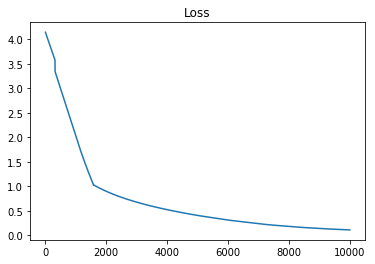

In [9]:
plt.plot(np.linspace(0, NUM_EPOCHS, num=NUM_EPOCHS), losses)
plt.title('Loss')
plt.show()

In [10]:
def extract_dims(space):
    return space[:, 0], space[:, 1], space[:, 2]

from scipy.spatial import ConvexHull
def add_hull(pts, ax, color='r'):
    # adapted from https://stackoverflow.com/a/43347024
    hull = ConvexHull(pts)
    
    # Plot defining corner points
    ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

    # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], color)

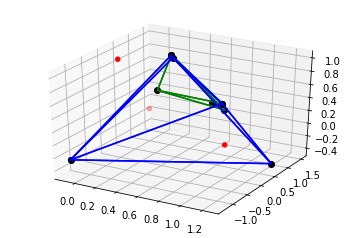

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

initial_x, initial_y, initial_z = extract_dims(initial_space)
ax.scatter3D(xs=initial_x, ys=initial_y, zs=initial_z, c='g')

final_x, final_y, final_z = extract_dims(final_space)
ax.scatter3D(xs=final_x, ys=final_y, zs=final_z, c='b')

data_x, data_y, data_z = extract_dims(train_data)
ax.scatter3D(xs=data_x, ys=data_y, zs=data_z, c='r')

add_hull(initial_space, ax, color='g')
add_hull(final_space, ax, color='b')

# Blue: final space
# Green: initial space
# Red: data points